![mercado libre logo](https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_170,w_170,f_auto,b_white,q_auto:eco/v1456160088/dauw8qmiutpmqx4wvwlf.png)

# Mercado Libre ML challenge - part 1

This notebook is the first part of my development on the ML job challenge. Here I extract data from Mercado Libre API and explore it. I've choosed to work with 'categories' data, I chose to work with the categories search API, looking for a dataset with more a heterogeneous range of products  

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_context('notebook')
sns.set_style('whitegrid')


## API sites available

In [5]:
r = requests.get('https://api.mercadolibre.com/sites')

In [6]:
sites = r.json()

In [7]:
sites

[{'default_currency_id': 'NIO', 'id': 'MNI', 'name': 'Nicaragua'},
 {'default_currency_id': 'BRL', 'id': 'MLB', 'name': 'Brasil'},
 {'default_currency_id': 'GTQ', 'id': 'MGT', 'name': 'Guatemala'},
 {'default_currency_id': 'PYG', 'id': 'MPY', 'name': 'Paraguay'},
 {'default_currency_id': 'HNL', 'id': 'MHN', 'name': 'Honduras'},
 {'default_currency_id': 'MXN', 'id': 'MLM', 'name': 'Mexico'},
 {'default_currency_id': 'USD', 'id': 'MSV', 'name': 'El Salvador'},
 {'default_currency_id': 'UYU', 'id': 'MLU', 'name': 'Uruguay'},
 {'default_currency_id': 'CUP', 'id': 'MCU', 'name': 'Cuba'},
 {'default_currency_id': 'USD', 'id': 'MEC', 'name': 'Ecuador'},
 {'default_currency_id': 'COP', 'id': 'MCO', 'name': 'Colombia'},
 {'default_currency_id': 'BOB', 'id': 'MBO', 'name': 'Bolivia'},
 {'default_currency_id': 'VES', 'id': 'MLV', 'name': 'Venezuela'},
 {'default_currency_id': 'DOP', 'id': 'MRD', 'name': 'Dominicana'},
 {'default_currency_id': 'CRC', 'id': 'MCR', 'name': 'Costa Rica'},
 {'default_

for this project i decided to choose one country to work with, Argentina ('MLA')

## API categories available

getting categories of products available

In [10]:
url_A =  'https://api.mercadolibre.com/sites/MLA/categories'
url_A_r = requests.get(url_A)

In [13]:
categories_arg = url_A_r.json()

In [96]:
categories_arg

[{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
 {'id': 'MLA1512', 'name': 'Agro'},
 {'id': 'MLA1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MLA1071', 'name': 'Animales y Mascotas'},
 {'id': 'MLA1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MLA1368', 'name': 'Arte, Librería y Mercería'},
 {'id': 'MLA1743', 'name': 'Autos, Motos y Otros'},
 {'id': 'MLA1384', 'name': 'Bebés'},
 {'id': 'MLA1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MLA1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MLA1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MLA1648', 'name': 'Computación'},
 {'id': 'MLA1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MLA1500', 'name': 'Construcción'},
 {'id': 'MLA1276', 'name': 'Deportes y Fitness'},
 {'id': 'MLA5726', 'name': 'Electrodomésticos y Aires Ac.'},
 {'id': 'MLA1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MLA2547', 'name': 'Entradas para Eventos'},
 {'id': 'MLA407134', 'name': 'Herramientas'},
 {'id': 'MLA1574', 'name': 'H

## Exploratory Analysis of Categories and Items

For the first part of the challenge, I've decided to explore data from different categories and compare them, and utilize the same generated data set to train a Machine Learning model to predict 'sold_quantity' of items in part 2. I thought it would be interesting to work with a wide variety of products instead of just a specific type for developing the predictive model.

some questions I wanted to answer in first part (EDA) was:

* What's the discount relationship of different categories (e.g., variation of percentage of products with discount and value of discount per categorie)
* Are the sold quantities related to amount of discount applied in items?

The attributes selected for the first part have been:

  * id
  * title
  * price
  * available_quantity
  * sold_quantity
  * buying_mode
  * condition
  * accepts_mercadopago
  * original_price
  * category_id

### Getting data from Mercado Libre's API

the above functions are used to extract the data from the API, `generate_category_df` extract data using 'category' attribute in search, and `generate_item_df` uses the 'item' search to make data extraction. both returns a pandas DataFrame with results. 

As I was using the public API, only 1000 offsets were allowed as shown in the returned message when trying to get items with an offset greater than 1000:

*('message': 'The requested offset is higher than the allowed. Maximum allowed without access_token is 1000')*

So in the first exploratory analysis i'm working with 1000 itens per category, and 1000 different items from a item search.

*note: I decided to return all features available from API instead of selecting them in the request, for later use in the machine learning model development section*




In [3]:
def generate_category_df(category_id, category_name):
    """
        function to obtain a dataset of items belonging to a specific category from ML API
        receives category_id and category_name and returns a pandas DataFrame 
    """
    offset=0
    df = pd.DataFrame()
    while True:

        try:
            r = requests.get('https://api.mercadolibre.com/sites/MLA/search?category={}&offset={}'.format(category_id,
                                                                                                            offset))
        except requests.exceptions.RequestException as e: 
            raise  SystemExit(e)
        if r.status_code != 200:
            break
        data = r.json()
        offset += data['paging']['limit']
        #convert json to pandas DataFrame
        data_df = pd.json_normalize(data['results']).dropna(axis=1, how='all')            
        df = df.append(data_df)
        df['general_category_name'] = category_name
        print('request status: ' + str(r.status_code),'current_offset: ' + str(offset))
    return df


def generate_item_df(item):
    """
        function to obtain a dataset of items from a item search in ML API, e.g."tv" 
        receives as input a string with name of item and returns a pandas DataFrame 
        
    """
    offset=0
    df = pd.DataFrame()
    while True:

        try:
            r = requests.get('https://api.mercadolibre.com/sites/MLA/search?q=tv&offset={}'.format(offset))
        except requests.exceptions.RequestException as e: 
            raise  SystemExit(e)
        if r.status_code != 200:
            break
        data = r.json()
        offset += data['paging']['limit']
        #convert json to pandas DataFrame
        data_df = pd.json_normalize(data['results']).dropna(axis=1, how='all')            
        df = df.append(data_df)
        
        print('request status: ' + str(r.status_code),'current_offset: ' + str(offset))
    return df

In [4]:
features = [
  'id',
 'title',
 'price',
 'available_quantity',
 'sold_quantity',
 'condition',
 'accepts_mercadopago',
 'original_price',
  'seller.seller_reputation.transactions.completed',
 'seller.seller_reputation.transactions.ratings.positive',
 'seller.seller_reputation.transactions.ratings.negative',
 'seller.seller_reputation.metrics.sales.completed',
  'seller.seller_reputation.metrics.sales.period',
  'seller.seller_reputation.metrics.cancellations.rate',
   'seller.seller_reputation.metrics.claims.rate',
    'installments.quantity',
 'installments.amount',
 'installments.rate',
  'shipping.free_shipping',
  'shipping.mode',
]

## Common features between the category search and item search from API

In [96]:
available_features_in_item = set(item_df.columns) & set(features)

In [97]:
available_features_in_item

{'accepts_mercadopago',
 'available_quantity',
 'condition',
 'original_price',
 'price',
 'shipping.free_shipping',
 'shipping.mode',
 'sold_quantity'}

In [ ]:
pets_df = generate_category_df('MLA1071', 'Animales y Mascotas')
art_df = generate_category_df( 'MLA1368', 'Arte, Librería y Mercería')
auto_df = generate_category_df( 'MLA1743', 'Autos, Motos y Otros')
beauty_df = generate_category_df('MLA1246', 'Belleza y Cuidado Personal')
cameras_df = generate_category_df( 'MLA1039',  'Cámaras y Accesorios')

In [ ]:
food_df = generate_category_df('MLA1403', 'Alimentos y Bebidas')

In [11]:
print('Number of duplicated columns:',food_df[attributes_list].duplicated().sum())

Number of duplicated columns: 0


In [ ]:
cell_df = generate_category_df('MLA1051', 'Celulares y Teléfonos')

In [12]:
print('Number of duplicated columns:',cell_df[attributes_list].duplicated().sum())

Number of duplicated columns: 0


In [ ]:
comp_df = generate_category_df('MLA1648', 'Computación')

In [29]:
print('Number of duplicated columns:',comp_df[attributes_list].duplicated().sum())

Number of duplicated columns: 6


In [ ]:
df_household= generate_category_df('MLA5726', 'Electrodomésticos y Aires Ac.')


In [27]:
print('Number of duplicated columns:',df_household[attributes_list].duplicated().sum())

Number of duplicated columns: 7


In [ ]:
books_df = generate_category_df('MLA3025', 'Libros, Revistas y Comics')

In [21]:
print('Number of duplicated columns:', books_df[attributes_list].duplicated().sum())

Number of duplicated columns: 13


In [ ]:
eletro_df = generate_category_df('MLA1000', 'Electrónica, Audio y Video')

In [23]:
print('Number of duplicated columns:', eletro_df[attributes_list].duplicated().sum())

Number of duplicated columns: 0


In [ ]:
clothes_df = generate_category_df('MLA1430', 'Ropa y Accesorios')

In [25]:
print('Number of duplicated columns:', clothes_df[attributes_list].duplicated().sum())

Number of duplicated columns: 0


In [ ]:
music_df = generate_category_df('MLA1168',  'Música, Películas y Series')


In [81]:
categories_df = pd.concat([food_df, clothes_df, eletro_df, cell_df, books_df, 
                           df_household, music_df, comp_df,pets_df,
                            art_df, 
                            auto_df, 
                            beauty_df, 
                            cameras_df, ])

In [8]:
filter_df = ['id',
 'title',
 'price',
 'available_quantity',
 'sold_quantity',
 'buying_mode',
 'stop_time',
 'condition',
 'accepts_mercadopago',
 'original_price',
 'category_id',
  'general_category_name',

]

In [6]:
categories_df = pd.read_pickle('categoriesDF.pkl')

In [82]:
categories_df.reset_index().to_pickle('./categoriesDF.pkl')

In [9]:
categories_df = categories_df[filter_df].drop_duplicates().reset_index()

In [10]:
categories_df.shape

(13595, 13)

### Building some features


Some feature engineering to help with the analysis:

* **discount_value:** amount of discount of a given product (numerical)
* **discount_pct:** percentage of discount applied in a given product (numerical)
* **sold_qtt_pct:** percentage of sold items for a given product (numerical)
* **has_discount:** categorical variable to identify if a product has discount applied (categorial)

In [11]:
categories_df['discount_value'] = categories_df['original_price'] - categories_df['price']
categories_df['discount_pct'] = categories_df['discount_value']/categories_df['original_price']
categories_df['sold_qtt_pct'] = categories_df['sold_quantity']/categories_df['available_quantity']
categories_df['has_discount'] = categories_df.discount_value.apply(lambda val: 'no' if str(val) == 'nan' else 'yes')

In [12]:
categories_df['discount_value'].fillna(value=0, inplace=True)
categories_df['discount_pct'].fillna(value=0, inplace=True)

In [162]:
def features_build(df):
    df['discount_value'] = df['original_price'] - df['price']
    df['discount_pct'] = df['discount_value']/df['original_price']
    df['sold_qtt_pct'] = df['sold_quantity']/df['available_quantity']
    df['has_discount'] = df.discount_value.apply(lambda val: 'no' if str(val) == 'nan' else 'yes')
    df['discount_value'].fillna(value=0, inplace=True)
    df['discount_pct'].fillna(value=0, inplace=True)

[]

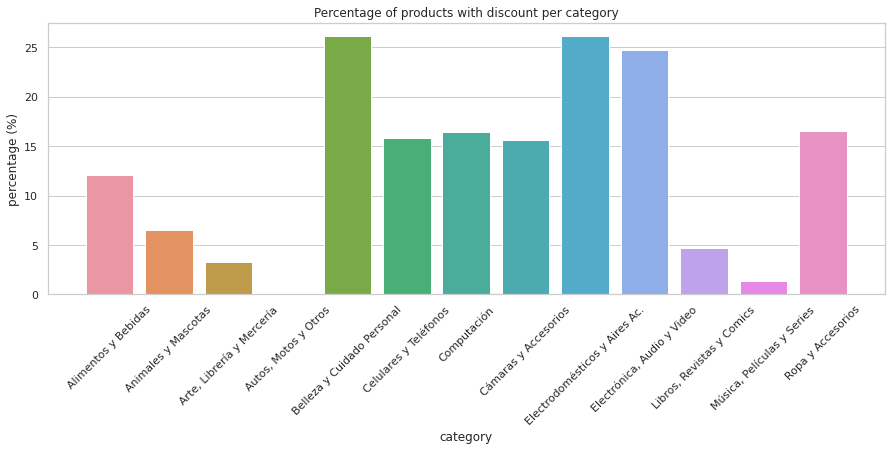

In [13]:
plt.figure(figsize=(15,5))
data = pd.DataFrame(categories_df.groupby(['general_category_name']).apply(lambda x: x.notnull().mean())['original_price']*100)
sns.barplot(x='general_category_name', y='original_price', data=data.reset_index())
plt.xlabel('category')
plt.xticks(rotation=45)

plt.ylabel('percentage (%)')
plt.title('Percentage of products with discount per category')
plt.plot()

selecting items with discount in `categories_df`

In [14]:
cat_df_with_discount = categories_df.loc[categories_df.has_discount == 'yes']

[]

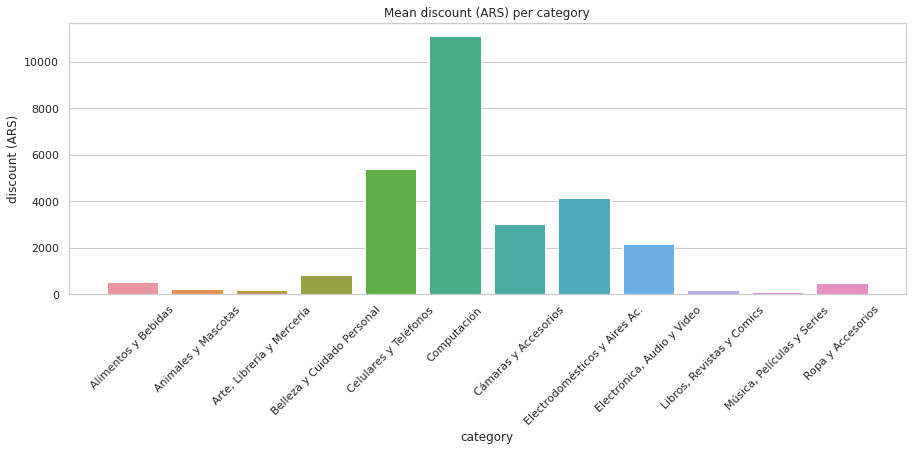

In [15]:
plt.figure(figsize=(15,5))
mean_discount = cat_df_with_discount[['discount_value', 'general_category_name']].groupby('general_category_name').mean().reset_index()
plt.title('Mean discount (ARS) per category')
sns.barplot(data=mean_discount, x='general_category_name', y='discount_value')
plt.ylabel('discount (ARS)')
plt.xlabel('category')
plt.xticks(rotation=45)
plt.plot()

[]

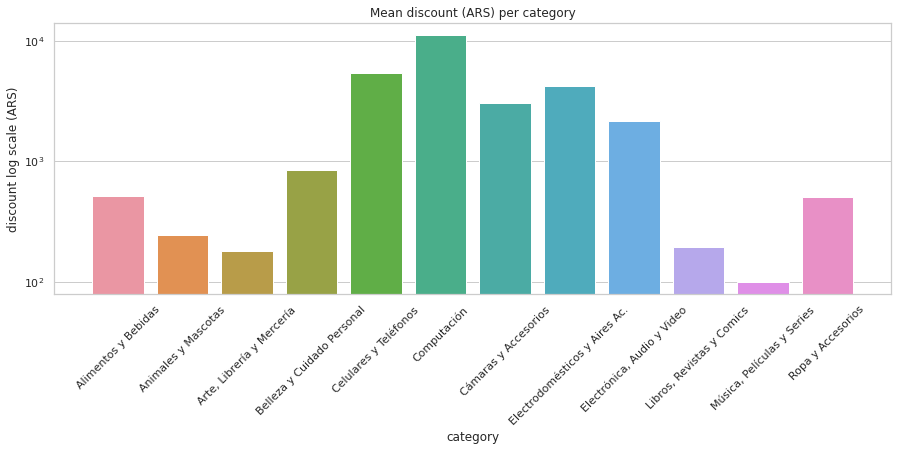

In [16]:
f, ax = plt.subplots(figsize=(15, 5))
ax.set_yscale("log")
mean_discount = cat_df_with_discount[['discount_value', 'general_category_name']].groupby('general_category_name').mean().reset_index()
plt.title('Mean discount (ARS) per category')
sns.barplot(data=mean_discount, x='general_category_name', y='discount_value')
plt.ylabel('discount log scale (ARS)')
plt.xlabel('category')
plt.xticks(rotation=45)
plt.plot()

[]

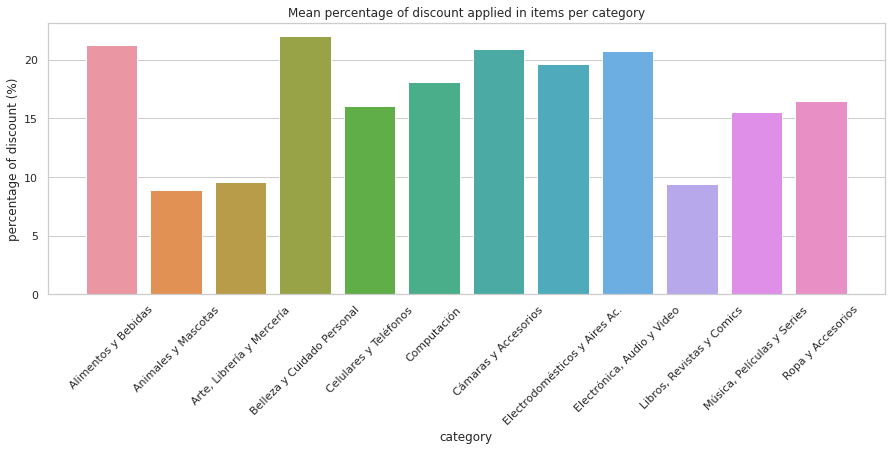

In [17]:
plt.figure(figsize=(15,5))
mean_pct_discount = cat_df_with_discount[['discount_pct', 'general_category_name']].groupby('general_category_name').mean().reset_index() 
plt.title('Mean percentage of discount applied in items per category')
sns.barplot(data=mean_pct_discount, x='general_category_name', y=(mean_pct_discount['discount_pct']*100))
plt.ylabel('percentage of discount (%)')
plt.xlabel('category')
plt.xticks(rotation=45)

plt.plot()

[]

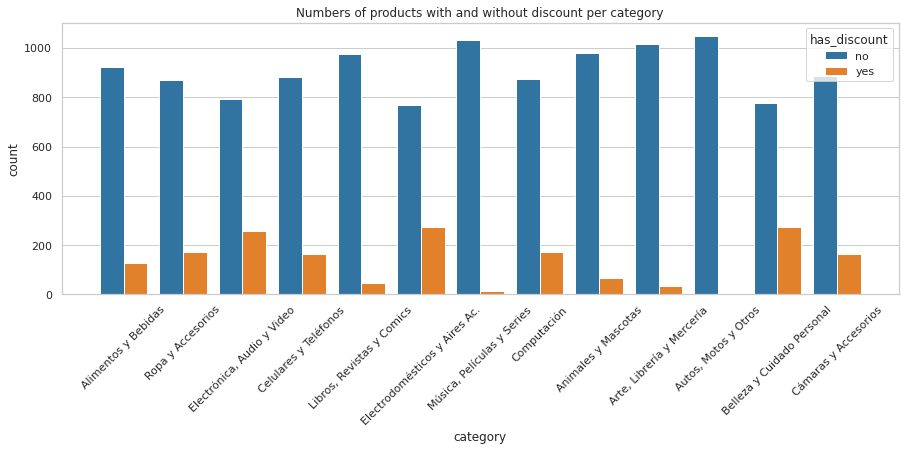

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(data=categories_df, x='general_category_name', hue='has_discount')
plt.xlabel('category')
plt.xticks(rotation=45)

plt.ylabel('count')
plt.title('Numbers of products with and without discount per category')
plt.plot()

[]

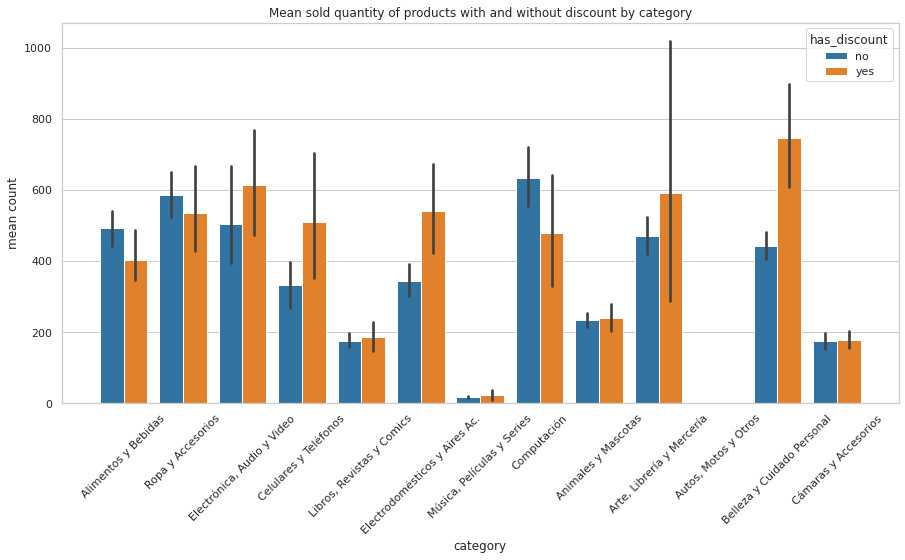

In [19]:
plt.figure(figsize=(15,7))

sns.barplot(data=categories_df, x='general_category_name', y='sold_quantity', hue='has_discount', ci=95)
plt.title('Mean sold quantity of products with and without discount by category')
plt.xlabel('category')
plt.xticks(rotation=45)

plt.ylabel('mean count')
plt.plot()

[]

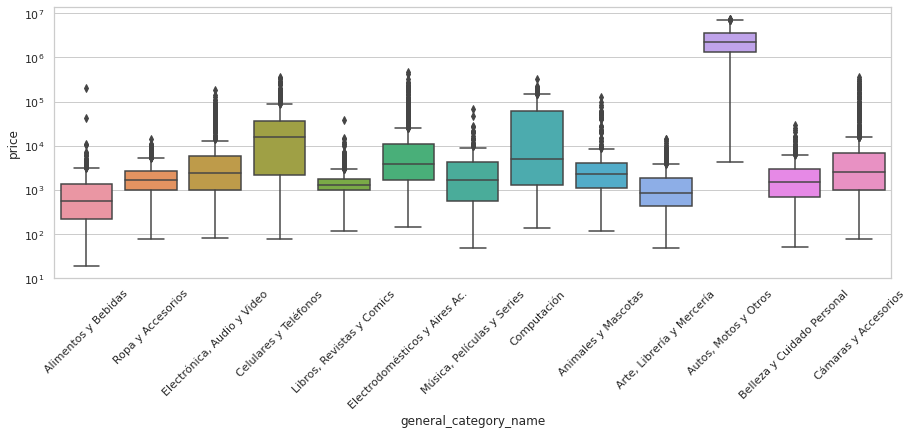

In [20]:
f, ax = plt.subplots(figsize=(15, 5))
ax.set_yscale("log")
sns.boxplot(data=categories_df, x='general_category_name', y='price')
plt.xticks(rotation=45)
plt.plot()